In [1]:
import tensorflow as tf
from tensorflow import keras
from tqdm.keras import TqdmCallback
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
def poiseuille(R=1,dpdx=-0.01,nu=0.01,Nr=100,figure=True):
  
    r = np.linspace(-R,R,Nr)
    u = -1/4/nu *dpdx*(R**2-r**2)
    if figure:
        fig, ax = plt.subplots(figsize=(10,4))
        ax.scatter(r,u)
        ax.set_ylabel("u [m/s]")
        ax.set_xlabel("r [m]")
    umax = -1/4/nu*dpdx*R*R
    Re = umax*2*R/nu
    return Re,r,u

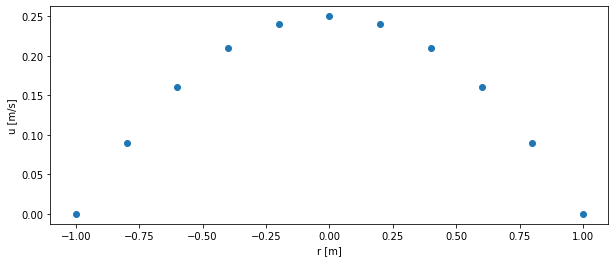

In [3]:
Re, r, u = poiseuille(R=1,dpdx=-0.01,nu=0.01,Nr=11,figure=True)

In [4]:
Re

50.0

In [5]:
# making the samples
rey   = []
perf  = []
rp    = []
for presion in np.linspace(0,0.7,1000):
    re, r, u = poiseuille(R=1,dpdx=-presion,nu=0.01,Nr=11,figure=False)
    rey.append([re])
    perf.append(u)
    rp.append(r)
# lists to array and scale
reynolds_array = np.array(rey)
reynolds_scale = reynolds_array/reynolds_array.max()
profile_array  = np.array(perf)
profile_scale  = profile_array/profile_array.max()
# split test(0.2) and train(0.8) arrays
train_reynolds, test_reynolds, train_profile, test_profile = train_test_split(reynolds_scale,
                                                                              profile_scale,
                                                                              train_size=0.8,
                                                                              test_size=0.2)

In [6]:
np.shape(train_reynolds)

(800, 1)

In [7]:
# creating layers
inputs = tf.keras.Input(shape=1, name='input')
hidden = tf.keras.layers.Dense(22, activation='relu', name='hidden1')(inputs)
output = tf.keras.layers.Dense(11, name='output')(hidden)
# creating the model
model  = keras.Model(inputs, output, name='model')
# printing
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 1)]               0         
                                                                 
 hidden1 (Dense)             (None, 22)                44        
                                                                 
 output (Dense)              (None, 11)                253       
                                                                 
Total params: 297
Trainable params: 297
Non-trainable params: 0
_________________________________________________________________


In [8]:
# compiling the model
optimizer = tf.keras.optimizers.Adamax(learning_rate=0.1)
loss      = tf.keras.losses.MeanSquaredError()
model.compile(optimizer, loss, metrics=['mae'])
fitting = model.fit(train_reynolds, train_profile, batch_size=20, epochs=300, verbose=0)

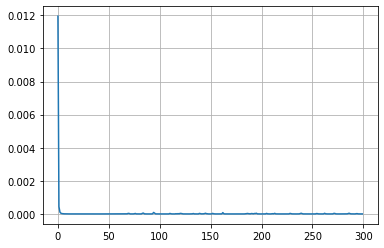

In [9]:
plt.plot(fitting.history['loss'])
plt.grid('on')

In [10]:
# test the model
test   = model.predict([test_reynolds])
test50 = model.predict([50/reynolds_array.max()])

1/1 [==============================] - 0s 135ms/step


In [11]:
np.shape(test)

(200, 11)

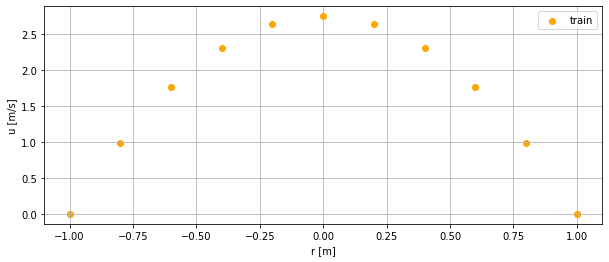

In [12]:
# plot
fig, ax = plt.subplots(figsize=(10,4))

ax.scatter(r,test[0]*profile_array.max(), label='train', color='orange')

ax.set_xlabel('r [m]')
ax.set_ylabel('u [m/s]')
ax.legend()
ax.grid()

In [13]:
# validation data set
r_v = []
for presion in np.linspace(0.5,1,100):
    re, r, u = poiseuille(R=1,dpdx=-presion,nu=0.01,Nr=11,figure=False)
    r_v.append([re])
    
# lists to array and scale
r_array = np.array(r_v)
r_validation = r_array/r_array.max()

In [14]:
# test the model
test_v = model.predict([r_validation])

4/4 [==============================] - 0s 4ms/step


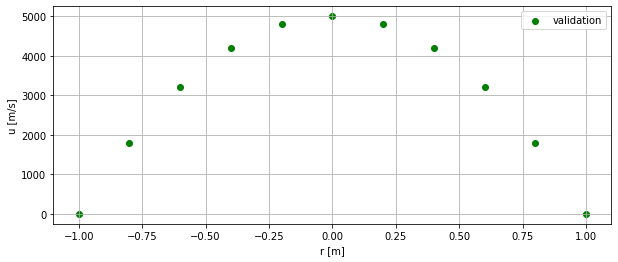

In [16]:
# plot
fig, ax = plt.subplots(figsize=(10,4))

ax.scatter(r,test_v[99]*r_array.max(), label='validation', color='green')

ax.set_xlabel('r [m]')
ax.set_ylabel('u [m/s]')
ax.legend()
ax.grid()